# Multi-class Classification with VGG16 on CIFAR-10 using PyTorch

In [ ]:
!pip install torch torchvision scikit-learn --quiet

### Import Required Libraries
- Import PyTorch modules, torchvision models, transforms, optimizers.
- Import additional libraries for metrics and visualization.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

### Set Device
- Set the computation device to GPU (if available) or CPU.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Define Data Transforms
- Resize CIFAR-10 images from 32×32 to 224×224 to fit VGG16 input.
- Apply data augmentation (horizontal flip, rotation) for training.
- Normalize image tensors.

In [4]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

### Load CIFAR-10 Dataset
- Download training and test datasets using `torchvision.datasets`.
- Split training data into training and validation sets.

In [ ]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

In [6]:
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

### Create DataLoaders
- Wrap train, validation, and test sets into `DataLoader` for batching.

In [7]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Load Pretrained VGG16 Model
- Load VGG16 with pretrained weights from ImageNet.
- Freeze feature extractor layers (`vgg16.features`) to use as fixed feature extractor.


In [ ]:
vgg16 = models.vgg16(pretrained=True)
for param in vgg16.features.parameters():
    param.requires_grad = False  # Freeze base layers

### Modify Classifier Head for CIFAR-10
- Replace the last fully connected layer (1000 outputs) with:
  - Linear → ReLU → Dropout → Linear (10-class output).

In [11]:
vgg16.classifier[6] = nn.Sequential(
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 10)
)

model = vgg16.to(device)

<img src="https://raw.githubusercontent.com/blurred-machine/Data-Science/master/Deep%20Learning%20SOTA/img/network.png">

<img src="https://www.researchgate.net/publication/322512435/figure/fig3/AS:697390994567179@1543282378794/Fig-A1-The-standard-VGG-16-network-architecture-as-proposed-in-32-Note-that-only.png">

In [21]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Define Loss Function and Optimizer
- Use `CrossEntropyLoss` for multi-class classification.
- Use `Adam` optimizer with learning rate suited for feature extraction.


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

### Train the Model (Feature Extraction Phase)
- Train only the new classification head (rest of the model frozen).
- Monitor training loss.

In [13]:
for epoch in range(1):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.8529


### Fine-Tuning (Unfreeze Last Few Conv Layers)
- Unfreeze selected layers of VGG16 feature extractor.
- Re-compile optimizer with smaller learning rate for fine-tuning.
- Train entire model with limited updates to pretrained layers.

In [14]:
for param in vgg16.features[-4:].parameters():
    param.requires_grad = True

In [15]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

In [16]:
for epoch in range(1):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"[Fine-tuning] Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

[Fine-tuning] Epoch 1, Loss: 0.5310


### Evaluate the Model on Test Set
- Set model to `eval()` mode and disable gradient computation.
- Collect predicted and actual labels.

In [17]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

### Confusion Matrix
- Compute and visualize the confusion matrix to analyze true positives, false positives, etc.
- Use seaborn’s heatmap for better visualization.

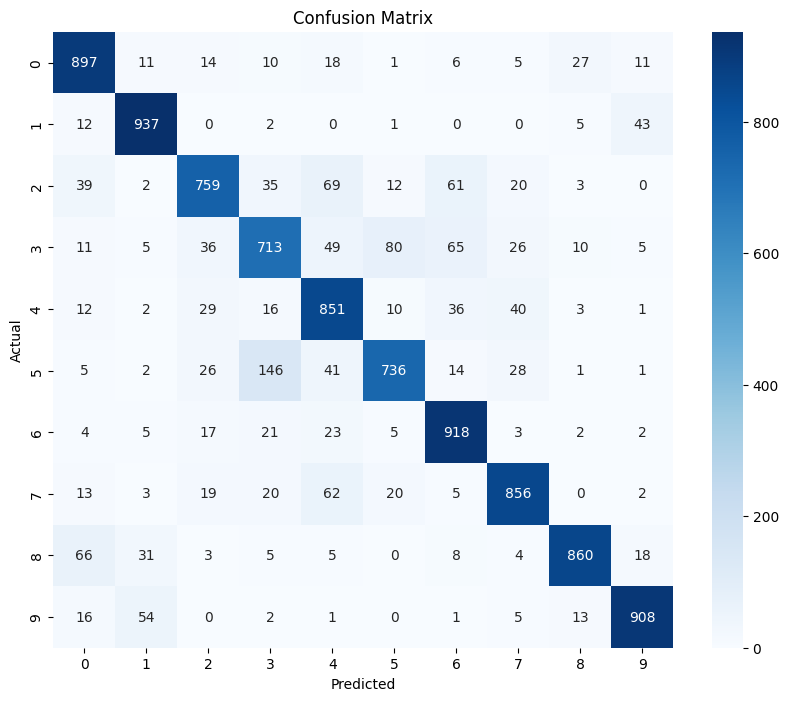

In [18]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Classification Report
- Generate precision, recall, F1-score, and support for both classes.
- Provides deeper insights into model performance beyond accuracy.

In [19]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1000
           1       0.89      0.94      0.91      1000
           2       0.84      0.76      0.80      1000
           3       0.74      0.71      0.72      1000
           4       0.76      0.85      0.80      1000
           5       0.85      0.74      0.79      1000
           6       0.82      0.92      0.87      1000
           7       0.87      0.86      0.86      1000
           8       0.93      0.86      0.89      1000
           9       0.92      0.91      0.91      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000

